# Multi Graph Evolution

Graph evolution for multiple algorithms and datasets.

In [5]:
import os
import time
import networkx as nx

# local imports
from utils.metrics import Recorder

In [6]:
# methods
WAGNER = "from methods import Wagner2022 as Method"
OTHERMETHOD = "from methods import OtherMethod as Method" # just an example for now

# datasets
CONGRESS = "congress", True
EMAIL_EU = "email_eu", True
WIKI_VOTE = "wiki_vote", True
FACEBOOK = "facebook", False
LASTFM = "lastfm", False
DEEZER = "deezer", False

# walk based algorithms
NODE2VEC = "import algs.node2vec as alg"
NODESIM = "import algs.nodesim as alg"
FAIRWALK = "import algs.fairwalk as alg"

# pagerank based algorithms
PPR = "import algs.ppr as alg"
ULOCALPPR = "import algs.ulocal_fair_ppr as alg"
NLOCALPPR = "import algs.nlocal_fair_ppr as alg"
PLOCALPPR = "import algs.plocal_fair_ppr as alg"

# percentages of the nodes considered to be the minorities
## NEEDS to match filenames in input/
PERCENT10 = "10percent"
PERCENT15 = "15percent"
PERCENT20 = "20percent"
PERCENT25 = "25percent"
PERCENT30 = "30percent"

# to test
methods = [ WAGNER ]
datasets = [ CONGRESS ]
alg_imports = [ FAIRWALK ]
minority_percentages = [ PERCENT10 ]

# Graph Evolution
ITERATIONS = 3
RESET_EVOLUTION = True

# Constants for I/O
INPUT_DIR = "../input"
DATA_DIR = "../data"

In [7]:
def add_edges(nx_g, directed, edges):
    """
    Adds edges to given graph.
    """
    nx_g.add_edges_from(edges)
    if not directed:
        nx_g.add_edges_from([(v, u) for (u, v) in edges])


def remove_edges(nx_g, directed, edges):
    """
    Removes edges from given graph.
    """
    nx_g.remove_edges_from(edges)
    if not directed:
        nx_g.remove_edges_from([(v, u) for (u, v) in edges])


def get_minority_nodes(file_path):
    """
    Returns a list of minority nodes.
    """
    minorities = []
    with open(file_path, "r") as f:
        for line in f:
            node = int(line.strip())
            minorities.append(node)
    return minorities


def get_graph(file_path, directed):
    """
    Returns directed and undirected graphs as DiGraph.
    """
    init_g = nx.read_edgelist(file_path, create_using=nx.DiGraph(), nodetype=int)
    if not directed:
        init_g.add_edges_from([(v, u) for (u, v) in init_g.edges()])
    return init_g


def evolve_network(nx_g, directed, minorities, recorder, method):
    """
    Iteratively evolve the network by adding and removing edges.
    """
    # initialize algorithm
    nx_g = alg.initialize(nx_g, directed=directed, protected=minorities)

    print("Iteration")
    print(f"0: {nx_g}")

    for i in range(1, ITERATIONS+1):

        to_predict = method.nodes_to_predict(nx_g)
        predictions = alg.predict(nx_g, directed=directed, nodes=to_predict)
        add_edges(nx_g, directed, predictions)

        removals = method.edges_to_remove(nx_g)
        remove_edges(nx_g, directed, removals)

        # compute metrics
        recorder.record_metrics(nx_g.copy())
  
        if i % 2 == 0:
            print(f"{i}: {nx_g}")
    
    return nx_g

Method: Wagner2022
Dataset: congress
Algorithm: algs.fairwalk
Iteration
0: DiGraph with 475 nodes and 13289 edges
2: DiGraph with 475 nodes and 13289 edges
Time elapsed: 6.7581787109375


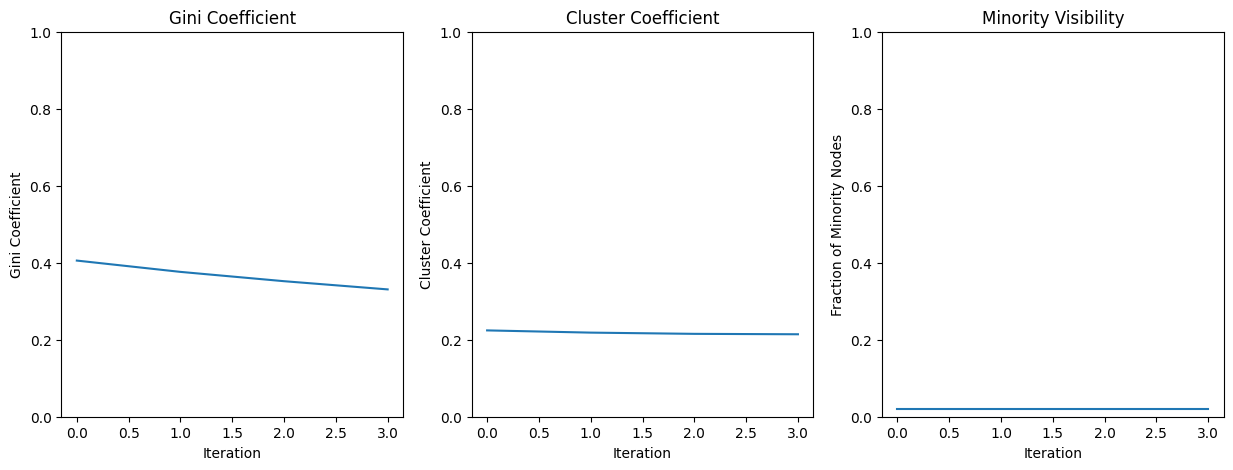

In [8]:
for percent in minority_percentages:
    # output directory for this minoritypercentage
    OUTPUT_DIR = os.path.join(DATA_DIR, percent)

    # create output directory if it doesn't exist
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    # for each method to test
    for method_import in methods:
        exec(method_import) # import the method

        # for each dataset to test
        for basename, directed in datasets:

            # for each algorithm to test
            for alg_import in alg_imports:
                exec(alg_import) # import the algorithm

                # file paths
                ouput_prefix = f"{basename}.{Method.NAME}.{alg.NAME}"
                minorities_path = os.path.join(INPUT_DIR, basename + percent + ".minorities")
                edgelist_path = os.path.join(INPUT_DIR, basename + ".txt")
                evolved_edgelist_path = os.path.join(OUTPUT_DIR, ouput_prefix + ".txt")

                minorities = get_minority_nodes(minorities_path)

                # initialize recorder
                recorder = Recorder(directed=directed,
                                    protected=minorities,
                                    output_dir=OUTPUT_DIR,
                                    output_prefix=ouput_prefix)
                
                if RESET_EVOLUTION:
                    init_g = get_graph(edgelist_path, directed)
                    recorder.clear_files()
                    recorder.record_metrics(init_g)
                else:
                    try:
                        init_g = get_graph(evolved_edgelist_path, directed)
                    except FileNotFoundError:
                        print(f"Error: {evolved_edgelist_path} not found. Skipping dataset.")
                        continue # skip if not found
                
                # initialize method
                method = Method(init_g, directed=directed, protected=minorities)

                print(f"Method: {Method.__name__}")
                print(f"Dataset: {basename}")
                print(f"Algorithm: {alg.__name__}")

                # evolve the network
                start = time.time()
                final_g = evolve_network(init_g, directed, minorities, recorder, method)
                end = time.time()
                print(f"Time elapsed: {end - start}")

                # plot metrics
                recorder.plot_metrics()

                # write evolved graph to file
                if directed:
                    nx.write_edgelist(final_g, evolved_edgelist_path, data=False)
                else:
                    nx.write_edgelist(final_g.to_undirected(), evolved_edgelist_path, data=False)